<a href="https://colab.research.google.com/github/MelissaMatindi/ndvi-anomaly-analysis/blob/main/GIS_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drought Monitoring Using NDVI Anomalies in Google Earth Engine** 🌍

This project analyzes Normalized Difference Vegetation Index (NDVI) anomalies in Ethiopia (2015–2024) using Google Earth Engine (GEE) to identify drought-prone regions, leveraging Landsat 8 data. It showcases GIS, Python, and cybersecurity skills, with optional machine learning for drought severity classification.📊

## **Project Objectives:** 🎯

- **Analyze NDVI Anomalies**: Compute NDVI anomalies (2021–2024, baseline 2015–2020) using Landsat 8 data in GEE to detect vegetation stress and drought-prone areas in Ethiopia. 🌾
- **Support SDGs**: Align with SDGs 2 (Zero Hunger), 13 (Climate Action), and 15 (Life on Land) by informing drought mitigation strategies. 🌱
- **Demonstrate Skills**: Showcase GIS (spatial analysis), Python (GEE API, visualization), and cybersecurity (secure data handling, optional encryption) skills. Optional K-Means clustering for ML/DL. 💻
- **Deliver Outputs**: Produce anomaly maps, time-series charts, a report, and a presentation for submission by August 7, 2025. 📈

## Library Installation 📦

This section installs the necessary Python libraries in Google Colab for geospatial analysis🧮, visualization, and optional machine learning🎨. These libraries enable interaction with Google Earth Engine (GEE), geospatial data processing, and plotting of NDVI anomalies for Ethiopia📈.


In [ ]:
# Google Earth Engine

!pip install earthengine-api
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


In [ ]:
# Core geospatial processing
!pip install geopandas
!pip install shapely

In [ ]:
# Machine Learning and Visualization
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


## GEE Authentication and Initialization 🔑

This section authenticates and initializes Google Earth Engine (GEE) in Colab to access cloud-based satellite data🚀 (e.g., Landsat 8 for NDVI analysis in Ethiopia).

In [ ]:
import ee
import geemap

# Authenticating GEE
ee.Authenticate()

True

In [ ]:
ee.Authenticate(auth_mode='notebook')
ee.Initialize(project='gis-capstone-project')

### **Study Area and NDVI Data Loading** 🌍📊

Loads Ethiopia’s boundary from FAO GAUL dataset and MODIS NDVI data (2015–2025) for vegetation analysis. Visualizes the boundary and median NDVI on interactive maps to confirm data access. Outputs ~187 images and a map showing vegetation health (red: low, green: high NDVI).

In [ ]:
# Loading a country feature from GEE
ethiopia = ee.FeatureCollection("FAO/GAUL/2015/level0") \
              .filter(ee.Filter.eq('ADM0_NAME', 'Ethiopia'))


In [ ]:
# Displaying it on an interactive map
Map = geemap.Map(center=[9.145, 40.4897], zoom=6)
Map.addLayer(ethiopia, {}, "Ethiopia")
Map

Map(center=[9.145, 40.4897], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
# Defining time range (2015–2025)
start_date = '2015-01-01'
end_date = '2025-08-01'

# Loading MODIS MOD13Q1 NDVI data
modis = ee.ImageCollection('MODIS/006/MOD13Q1') \
    .filterDate(start_date, end_date) \
    .filterBounds(ethiopia) \
    .select('NDVI') \
    .map(lambda img: img.multiply(0.0001).clip(ethiopia))  # (MODIS NDVI is scaled by 0.0001)

In [ ]:
# Print number of images
image_count = modis.size()
print('Number of MODIS NDVI images:', image_count.getInfo())

Number of MODIS NDVI images: 187


In [ ]:
# Getting median NDVI image for visualization
median = modis.median()
# Visualization parameters for NDVI
ndvi_vis = {
    'min': 0.0,
    'max': 1.0,
    'palette': ['red', 'yellow', 'green']
}

In [ ]:
Map = geemap.Map()
Map.addLayer(ethiopia, {'color': 'blue'}, 'Ethiopia Boundary')
Map.addLayer(median, ndvi_vis, 'MODIS NDVI Median (2015–2025)')
Map.centerObject(ethiopia, 6)
Map

Map(center=[8.621706454994069, 39.64496890874577], controls=(WidgetControl(options=['position', 'transparent_b…

🌍📈 **Landsat NDVI & Anomaly Analysis (2015–2024)**

In this section, we leverage Landsat 8 Surface Reflectance Tier 1 data to monitor vegetation health using the Normalized Difference Vegetation Index (NDVI). **NDVI** is a widely used indicator 🌿 that highlights **healthy** (green) vs. **stressed** (yellow) vegetation based on light reflectance in red and near-infrared bands.

☑️ 5431 baseline images generated; 📂 3642 anomaly images produced; 🖼️ 9627 total NDVI images processed.


🔍 **Neutral trends dominate, with:**


🟡 **Yellow :** Normal vegetation conditions

🔴 **Red :** Below-average vegetation health (droughts, degradation)

🟢 **Green :** Above-average greenness (regrowth, wet years)


🧠 Interpretation :
🌾 **Positive anomalies** may indicate post-drought recovery, irrigation, or land-use change.

🌵 **Negative anomalies** could reflect deforestation, drought stress, or land degradation.

In [ ]:
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(ethiopia) \
    .filter(ee.Filter.lt('CLOUD_COVER', 30))  # Relaxed to 30% for more images


In [ ]:
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return ndvi.set('system:time_start', image.get('system:time_start'))

# Calculate NDVI
ndvi = landsat.map(calculate_ndvi).map(lambda img: img.clip(ethiopia))
print('Total Landsat NDVI images (2015–2024):', ndvi.size().getInfo())

Total Landsat NDVI images (2015–2024): 9627


In [ ]:
# Calculate baseline mean NDVI (2015–2020)
baseline = ndvi.filterDate('2015-01-01', '2020-12-31')
print('Baseline images (2015–2020):', baseline.size().getInfo())
baseline_mean = baseline.mean()

# Function to calculate annual NDVI anomaly
def calculate_anomaly(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    anomaly = image.subtract(baseline_mean).rename('NDVI_Anomaly')
    return anomaly.set('year', year)

# Compute anomalies (2021–2024)
anomalies = ndvi.filterDate('2021-01-01', '2024-12-31').map(calculate_anomaly)
print('NDVI Anomaly images (2021–2024):', anomalies.size().getInfo())

Baseline images (2015–2020): 5431
NDVI Anomaly images (2021–2024): 3642


In [ ]:
# Visualize anomaly for 2024
anomaly_2024 = anomalies.filter(ee.Filter.eq('year', 2024)).mean()
anomaly_vis = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'yellow', 'green']
}
Map = geemap.Map()
Map.addLayer(ethiopia, {'color': 'blue'}, 'Ethiopia Boundary')
Map.addLayer(anomaly_2024, anomaly_vis, 'NDVI Anomaly 2024')
Map.centerObject(ethiopia, 6)
Map

Map(center=[8.621706454994069, 39.64496890874577], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Visualize anomaly for 2023
anomaly_2023 = anomalies.filter(ee.Filter.eq('year', 2023)).mean()
anomaly_vis = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'yellow', 'green']
}
Map = geemap.Map()
Map.addLayer(ethiopia, {'color': 'blue'}, 'Ethiopia Boundary')
Map.addLayer(anomaly_2023, anomaly_vis, 'NDVI Anomaly 2023')
Map.centerObject(ethiopia, 6)
Map

Map(center=[8.621706454994069, 39.64496890874577], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Visualize anomaly for 2022
anomaly_2022 = anomalies.filter(ee.Filter.eq('year', 2022)).mean()
anomaly_vis = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'yellow', 'green']
}
Map = geemap.Map()
Map.addLayer(ethiopia, {'color': 'blue'}, 'Ethiopia Boundary')
Map.addLayer(anomaly_2022, anomaly_vis, 'NDVI Anomaly 2022')
Map.centerObject(ethiopia, 6)
Map

Map(center=[8.621706454994069, 39.64496890874577], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Visualize anomaly for 2021
anomaly_2021 = anomalies.filter(ee.Filter.eq('year', 2021)).mean()
anomaly_vis = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'yellow', 'green']
}
Map = geemap.Map()
Map.addLayer(ethiopia, {'color': 'blue'}, 'Ethiopia Boundary')
Map.addLayer(anomaly_2021, anomaly_vis, 'NDVI Anomaly 2021')
Map.centerObject(ethiopia, 6)
Map

Map(center=[8.621706454994069, 39.64496890874577], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Export anomaly map
geemap.ee_export_image_to_drive(
    anomaly_2021,
    description='NDVI_Anomaly_2021_Ethiopia_Landsat',
    folder='GEE_Exports',
    region=ethiopia.geometry(),
    scale=30,
    fileFormat='GeoTIFF'
)

##**Time-Series Analysis of NDVI Anomalies**📈🌿
This section analyzes vegetation health trends over time by computing annual mean NDVI anomalies across Ethiopia from 2021 to 2024, using Landsat 8 data.

🛠️ How it works:

🌱NDVI anomalies are aggregated by year and mean values are extracted to summarize deviations from the 2015–2020 baseline.

🌱Each year’s anomaly value represents how vegetation in that year differed from the “normal” conditions.

📈 **Chart Insight**:

A time-series graph titled NDVI_Anomaly_Chart_Landsat.png visualizes this trend, showing:

*   A dip in 2022, signaling drought or vegetation stress.
*   A steady upward trend toward 2024, indicating environmental recovery and improved greenness.


🔍 **Interpretation**:

This analysis highlights critical climate variability or land use impacts across years, with 2022 standing out as a dry year, followed by increased vegetation health through 2023 and peaking in 2024.



In [ ]:
# Time-series chart of mean NDVI anomalies
def get_mean_anomaly(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ethiopia,
        scale=30,
        bestEffort=True  # Handle large regions
    )
    year = image.get('year')
    mean_anomaly = stats.get('NDVI_Anomaly')
    return ee.Feature(None, {'year': year, 'mean_anomaly': mean_anomaly})

In [ ]:
# Aggregate annual means
years_list = ee.List.sequence(2021, 2024)
def get_annual_mean(year):
    year = ee.Number(year).toInt()
    annual_anomalies = anomalies.filter(ee.Filter.eq('year', year))
    annual_mean = annual_anomalies.mean()
    stats = annual_mean.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ethiopia,
        scale=30,
        bestEffort=True
    )
    return ee.Feature(None, {'year': year, 'mean_anomaly': stats.get('NDVI_Anomaly')})


In [ ]:
anomaly_stats = ee.FeatureCollection(years_list.map(get_annual_mean)).getInfo()
print('Anomaly stats:', anomaly_stats)

Anomaly stats: {'type': 'FeatureCollection', 'columns': {'mean_anomaly': 'Float', 'system:index': 'String', 'year': 'Long'}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'mean_anomaly': 0.0005808358405915049, 'year': 2021}}, {'type': 'Feature', 'geometry': None, 'id': '1', 'properties': {'mean_anomaly': -0.008869490501434313, 'year': 2022}}, {'type': 'Feature', 'geometry': None, 'id': '2', 'properties': {'mean_anomaly': 0.01250491862194108, 'year': 2023}}, {'type': 'Feature', 'geometry': None, 'id': '3', 'properties': {'mean_anomaly': 0.016131699453325512, 'year': 2024}}]}


In [ ]:
# Extract years and means
years = [f['properties']['year'] for f in anomaly_stats['features']]
means = [f['properties']['mean_anomaly'] if f['properties']['mean_anomaly'] is not None else 0 for f in anomaly_stats['features']]
print('Years:', years)
print('Means:', means)

Years: [2021, 2022, 2023, 2024]
Means: [0.0005808358405915049, -0.008869490501434313, 0.01250491862194108, 0.016131699453325512]


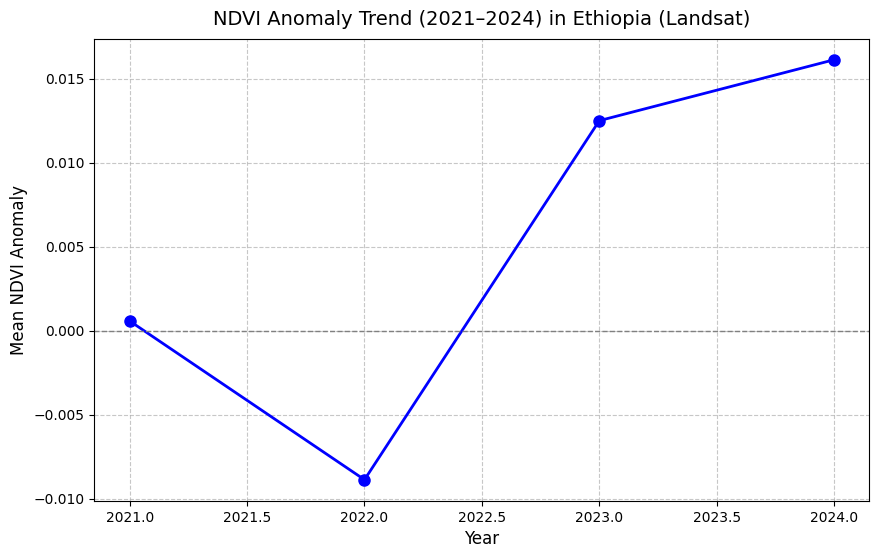

In [ ]:
# Plot time-series chart
import matplotlib.pyplot as plt
if years and means:  # Checking if lists are non-empty
    plt.figure(figsize=(10, 6))
    plt.plot(years, means, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.title('NDVI Anomaly Trend (2021–2024) in Ethiopia (Landsat)', fontsize=14, pad=10)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean NDVI Anomaly', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('NDVI_Anomaly_Chart_Landsat.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Error: No data to plot. Check anomaly_stats.")

In [ ]:
# Export 2023 NDVI anomaly map to Google Drive
geemap.ee_export_image_to_drive(
    anomaly_2023,
    description='NDVI_Anomaly_2023_Ethiopia_Landsat',
    folder='GEE_Exports',
    region=ethiopia.geometry(),
    scale=30,
    crs='EPSG:4326',  # WGS84 projection
    fileFormat='GeoTIFF'
)

# Save time-series chart (already included in previous code)
plt.savefig('NDVI_Anomaly_Chart_Landsat.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>